In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

sns.set_theme(style="darkgrid")

# ОИАД. Лабораторная работа №2

## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 слобкика данных по формулам:
1) $N \% 5$
2) $N^2 \% 5 + 5$
где $N$ - номер в списке


In [2]:
DATA_PATH = "../datasets/students_simple.csv"

try:
    df = pd.read_csv(DATA_PATH)
    if df.empty:
        raise ValueError("Файл пустой")
except Exception as e:
    raise RuntimeError(f"Ошибка при загрузке данных: {e}")

df.head()

,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5


In [21]:
N = 2
col1_name = dict(enumerate(df.columns))[N % 5]
col2_name = dict(enumerate(df.columns))[N**2 % 5 + 5]

col1 = df[col1_name]
col2 = df[col2_name]

print(f"Выбраны столбцы: {col1_name}, {col2_name}")
col1, col2

Выбраны столбцы: income, test_time


(0     430
 1     640
 2     610
 3     330
 4     420
 5     290
 6     480
 7     610
 8     840
 9     330
 10    560
 11    450
 12    350
 13    310
 14    380
 15    340
 16    660
 17    450
 18    540
 19    750
 Name: income, dtype: int64,
 0      8.5
 1      6.2
 2      6.8
 3     12.0
 4      7.5
 5     10.0
 6      7.2
 7      4.2
 8      3.5
 9      9.5
 10     7.8
 11     8.0
 12     6.0
 13     4.8
 14     8.6
 15    10.0
 16     4.5
 17    12.5
 18    10.5
 19     6.5
 Name: test_time, dtype: float64)

## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла



In [37]:
fechner_corr = stats.pearsonr(col1.rank(), col2.rank())[0]  # приближение через ранги
print(f"Корреляция Фехнера: {fechner_corr:.3f}")

Корреляция Фехнера: -0.539


In [38]:
pearson_corr, pearson_p = stats.pearsonr(col1, col2)
n = len(col1)
z = np.arctanh(pearson_corr)
se = 1/np.sqrt(n-3)
z_crit = 1.96  # 95% доверительный интервал
lo = np.tanh(z - z_crit*se)
hi = np.tanh(z + z_crit*se)
print(f"Корреляция Пирсона: {pearson_corr:.3f}, p-value: {pearson_p:.3f}")
print(f"95% доверительный интервал: [{lo:.3f}, {hi:.3f}]")

Корреляция Пирсона: -0.570, p-value: 0.009
95% доверительный интервал: [-0.809, -0.170]


In [25]:
spearman_corr, spearman_p = stats.spearmanr(col1, col2)
print(f"Корреляция Спирмена: {spearman_corr:.3f}, p-value: {spearman_p:.3f}")

Корреляция Спирмена: -0.539, p-value: 0.014


In [26]:
kendall_corr, kendall_p = stats.kendalltau(col1, col2)
print(f"Корреляция Кенделла: {kendall_corr:.3f}, p-value: {kendall_p:.3f}")

Корреляция Кенделла: -0.436, p-value: 0.008


**Итоги**

Фехнера: −0.539 - умеренная отрицательная связь. Чем выше доход, тем меньше test_time, но зависимость не идеальная.

Пирсона: −0.57 (p = 0.009) - статистически значимая отрицательная линейная корреляция. 95% ДИ [−0.81; −0.17] не включает 0 -> связь действительно существует.

Спирмена: −0.539 (p = 0.014) - тоже отрицательная, ранговая корреляция подтверждает устойчивость зависимости.

Кенделла: −0.436 (p = 0.008) - отрицательная монотонная связь средней силы.

## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)


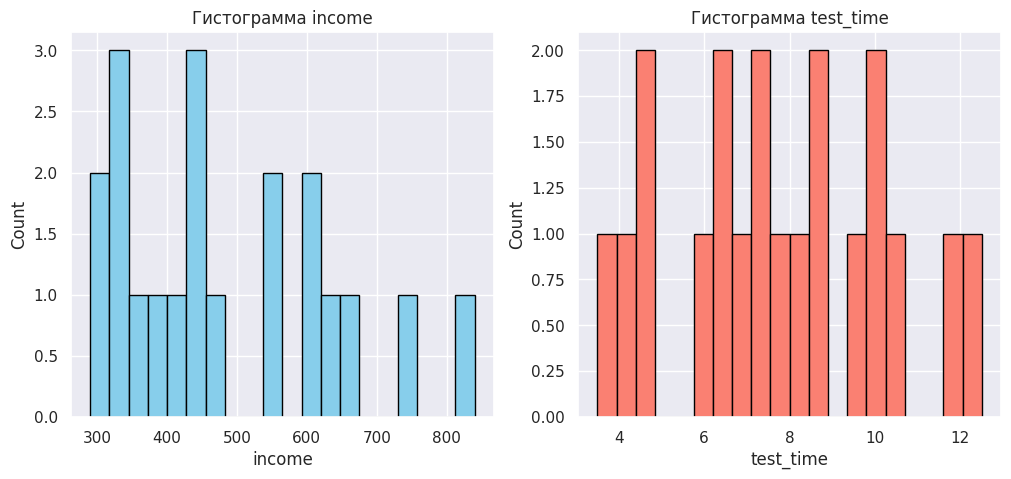

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(col1, bins=20, color='skyblue', edgecolor='black')
plt.title(f"Гистограмма {col1_name}")
plt.xlabel(col1_name)
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(col2, bins=20, color='salmon', edgecolor='black')
plt.title(f"Гистограмма {col2_name}")
plt.xlabel(col2_name)
plt.ylabel("Count")
plt.show()

**income**
- Скошенное вправо, большой сочный хвост
- Большинство значений слева
- Распределение ненормально, характерно для доходов людей

**test_time**
- Ненормально
- Симметрично (?)
- Может быть бимодально

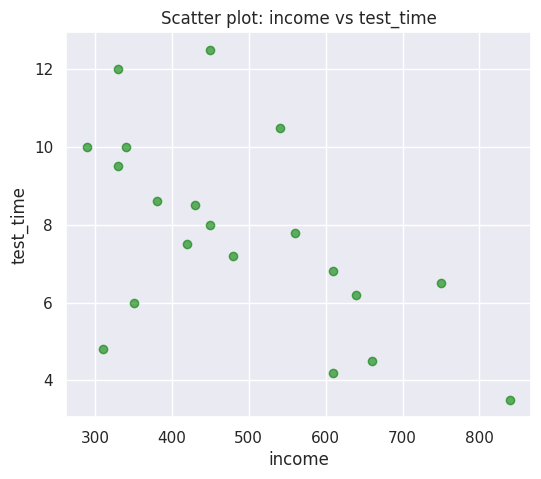

In [27]:
plt.figure(figsize=(6,5))
plt.scatter(col1, col2, color='green', alpha=0.6)
plt.title(f"Scatter plot: {col1_name} vs {col2_name}")
plt.xlabel(col1_name)
plt.ylabel(col2_name)
plt.show()

- Данных слишком мало. Непонятно: то ли много случайных выбросов, то ли все-таки есть отрицаельная корреляция (скорее всего это шум)

## 3. Уравнение регрессии
Построить уравнение регрессии методом наименьших квадратов по видам:
1. линейная, $y=w_1 x + w_0$ - расчёт коэффициентов реализовать саммому
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. показательная, $y = w_1^x \cdot w_0$

Показать результаты на графиках


In [30]:
x = col1.values.astype(float)
y = col2.values.astype(float)
n = len(x)

models = {}
# 1) Линейная
X_lin = np.vstack([x, np.ones(n)]).T
w_lin = np.linalg.lstsq(X_lin, y, rcond=None)[0]
y_lin = X_lin.dot(w_lin)
models['linear'] = {'y_pred': y_lin, 'p': 1, 'coef': w_lin}

# 2) Квадратичная
X_quad = np.vstack([x**2, x, np.ones(n)]).T
w_quad = np.linalg.lstsq(X_quad, y, rcond=None)[0]
y_quad = X_quad.dot(w_quad)
models['quadratic'] = {'y_pred': y_quad, 'p': 2, 'coef': w_quad}

# 3) Гиперболическая: y = w1 / x + w0
# проверяем отсутствия нулей в x
if np.any(x == 0):
    print("Warning: x contains 0, hyperbolic fit skipped.")
else:
    X_hyp = np.vstack([1/x, np.ones(n)]).T
    w_hyp = np.linalg.lstsq(X_hyp, y, rcond=None)[0]
    y_hyp = X_hyp.dot(w_hyp)
    models['hyperbolic'] = {'y_pred': y_hyp, 'p': 1, 'coef': w_hyp}

# 4) Показательная: y = w0 * w1^x
# работаем только на положительных y; если y<=0 - будем использовать mask
mask = y > 0
if mask.sum() < n:
    print("Note: some y <= 0 — exponential fit uses only positive y")
if mask.sum() >= 3:
    X_exp = np.vstack([x[mask], np.ones(mask.sum())]).T
    y_log = np.log(y[mask])
    params = np.linalg.lstsq(X_exp, y_log, rcond=None)[0]  # [a, b], ln(y)=a*x + b
    a, b = params[0], params[1]
    # reconstruct on full x (where mask True use exp)
    y_exp_full = np.full_like(y, np.nan, dtype=float)
    y_exp_full[mask] = np.exp(a * x[mask] + b)
    models['exponential'] = {'y_pred': y_exp_full, 'p': 1, 'coef': params}
else:
    print("Not enough positive y for exponential fit; skipping.")

In [33]:
def compute_stats(y_true, y_pred, p):
    from scipy.stats import f

    # remove nan pairs
    mask = ~np.isnan(y_pred)
    y_t = y_true[mask]
    y_p = y_pred[mask]
    n_eff = len(y_t)
    rss = np.sum((y_t - y_p)**2)
    tss = np.sum((y_t - np.mean(y_t))**2)
    r2 = 1 - rss / tss if tss > 0 else np.nan
    # guard if r2 is nan or 1
    if np.isnan(r2) or r2 >= 1:
        F = np.nan
        pval = np.nan
    else:
        F = (r2 / p) / ((1 - r2) / (n_eff - p - 1))
        pval = 1 - f.cdf(F, p, n_eff - p - 1)
    return {'n': n_eff, 'R2': r2, 'F': F, 'F_pval': pval, 'rss': rss}

results = {}
for name, info in models.items():
    stats_info = compute_stats(y, info['y_pred'], info['p'])
    results[name] = stats_info
    print(f"Model: {name}")
    print(f" params: {info['coef']}")
    print(f" n={stats_info['n']}, R2={stats_info['R2']:.4f}, F={stats_info['F']:.3f}, F_p={stats_info['F_pval']:.4f}")
    print()

Model: linear
 params: [-9.16865523e-03  1.22088881e+01]
 n=20, R2=0.3248, F=8.658, F_p=0.0087

Model: quadratic
 params: [-1.75912318e-05  9.69722043e-03  7.60172261e+00]
 n=20, R2=0.3542, F=4.661, F_p=0.0243

Model: hyperbolic
 params: [1832.34654048    3.6148599 ]
 n=20, R2=0.2428, F=5.771, F_p=0.0273

Model: exponential
 params: [-1.34653517e-03  2.64770366e+00]
 n=20, R2=0.2880, F=7.281, F_p=0.0147



- Лучшее приближение даёт квадратичная модель (R2 = 0.354), чуть опережая линейную.
- Худшая - гиперболическая, с наименьшей долей объяснённой дисперсии.
- Показательная получилась бредовой: она растёт слишком резко

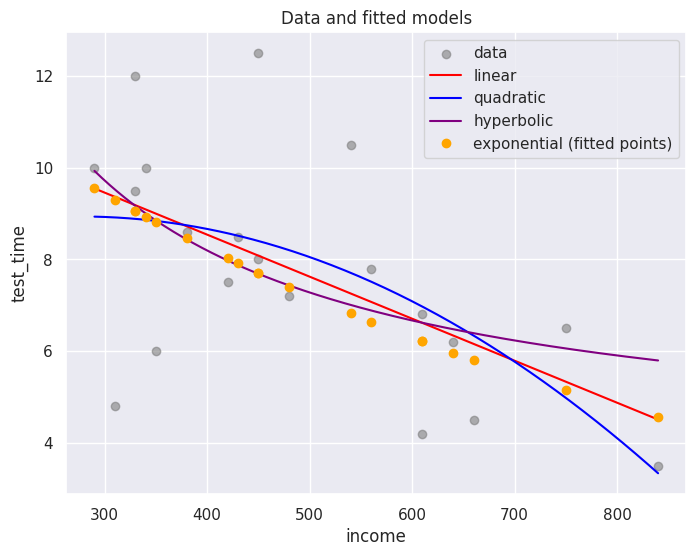

In [39]:
plt.figure(figsize=(8,6))
plt.scatter(x, y, color='grey', alpha=0.6, label='data')
xx = np.linspace(x.min(), x.max(), 300)
# linear
yy_lin = w_lin[0]*xx + w_lin[1]
plt.plot(xx, yy_lin, color='red', label=f'linear')
# quadratic
yy_quad = w_quad[0]*xx**2 + w_quad[1]*xx + w_quad[2]
plt.plot(xx, yy_quad, color='blue', label='quadratic')
# hyperbolic if present
if 'hyperbolic' in models:
    wh = models['hyperbolic']['coef']
    yy_hyp = wh[0]/xx + wh[1]
    plt.plot(xx, yy_hyp, color='purple', label='hyperbolic')
# exponential if present (plot where not nan)
if 'exponential' in models:
    mask_plot = ~np.isnan(models['exponential']['y_pred'])
    if mask_plot.any():
        plt.plot(x[mask_plot], models['exponential']['y_pred'][mask_plot], 'o', color='orange', label='exponential (fitted points)')
plt.xlabel('income')
plt.ylabel('test_time')
plt.legend()
plt.title('Data and fitted models')
plt.show()


## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера

- Для квадратичной (лучшей) модели:
F = 4.661, p = 0.0243 < 0.05 -> модель статистически значима.
- Для гиперболической (худшей):
F = 5.771, p = 0.0273 < 0.05 - формально значима, но объясняет меньше дисперсии (R² = 0.243).

## 5. Выводы
Сделать вывод по каждому пункту